In [ ]:
# Environment Setup
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers accelerate bitsandbytes datasets scipy matplotlib pandas tqdm wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset, concatenate_datasets
from tqdm.notebook import tqdm
import bitsandbytes as bnb
import pandas as pd
import numpy as np
import copy
import gc
import wandb
import time

# Verify Hardware
print(f"PyTorch: {torch.__version__}")
try:
    _ = torch.float8_e4m3fn
    print("✅ Hardware Ready: Native FP8 Supported.")
except AttributeError:
    raise RuntimeError("❌ Error: FP8 not supported. Use L4 or A100 GPU.")

device = "cuda"

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
PyTorch: 2.5.1+cu121
✅ Hardware Ready: Native FP8 Supported.


In [ ]:
# Set for reproducibility
import random
import numpy as np
from transformers import set_seed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **Configuration & Experiment Controls**

In [ ]:
# --- Experiment Settings ---
# Running a sweep across model sizes
MODELS_TO_TEST = [
    # "Qwen/Qwen2.5-0.5B-Instruct",
    "Qwen/Qwen2.5-1.5B-Instruct",
    "Qwen/Qwen2.5-3B-Instruct",
    "Qwen/Qwen2.5-7B-Instruct",
    "Qwen/Qwen2.5-14B-Instruct",
]
SENSITIVITY_THRESHOLDS = [0.0, 0.2]

CALIBRATION_SAMPLES = 128
EVAL_SAMPLES = 5000
WANDB_PROJECT_NAME = "KLD_Modelsize_test"

In [ ]:
import wandb
import pandas as pd
from datasets import load_dataset, concatenate_datasets
import os
os.environ["WANDB_QUIET"] = "true"

wandb.login()

if 'results_table' not in globals():
    results_table = []

print("Loading MMLU Dataset...")
try:
    mmlu_dataset = concatenate_datasets([
        load_dataset("cais/mmlu", "all", split='test')
    ])
    print(f"MMLU Dataset Loaded. Size: {len(mmlu_dataset)} samples.")
except Exception as e:
    print(f"Error loading MMLU: {e}")
    from datasets import Dataset
    mmlu_dataset = Dataset.from_dict({
        "question": ["1+1=?"], "choices": [["1", "2", "3", "4"]], "answer": [1]
    })

print("Global setup complete. Ready for Step 2.")

wandb: Currently logged in as: yq171014 (yq171014-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading MMLU Dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MMLU Dataset Loaded. Size: 14042 samples.
Global setup complete. Ready for Step 2.


## **Metrics & Helper Functions**

In [ ]:
def recursive_getattr(obj, attr):
    for part in attr.split('.'):
        obj = getattr(obj, part)
    return obj

def recursive_setattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    parent = recursive_getattr(obj, pre) if pre else obj
    setattr(parent, post, val)

In [ ]:
# --- Metrics Helpers ---
def compute_kld(logits_p, logits_q):
    p_probs = F.softmax(logits_p, dim=-1)
    q_log_probs = F.log_softmax(logits_q, dim=-1)
    return nn.KLDivLoss(reduction='batchmean')(q_log_probs, p_probs).item()

def calculate_flip_rate(base_preds, new_preds):
    """Calculates % of answers that changed from the baseline."""
    if not base_preds or not new_preds: return 0.0
    flips = sum([1 for b, n in zip(base_preds, new_preds) if b != n])
    return flips / len(base_preds)

def compute_perplexity(model, tokenizer):
    """Computes perplexity on a subset of WikiText-2"""
    encodings = tokenizer("\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:20]), return_tensors="pt")
    max_length = model.config.max_position_embeddings
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Computing PPL"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            nlls.append(outputs.loss)

        prev_end_loc = end_loc
        if end_loc == seq_len: break

    return torch.exp(torch.stack(nlls).mean()).item()

def measure_efficiency(model, tokenizer, input_text="Hello world"):
    # 1. Cleanup
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    # 2. Measure Static Memory (Model Weights Only)
    # This shows the pure effect of quantization storage
    static_mem_bytes = torch.cuda.memory_allocated()
    static_mem_gb = static_mem_bytes / 1024**3

    # 3. Run Inference
    input_ids = tokenizer(input_text, return_tensors="pt").to(device)
    start_time = time.time()
    with torch.no_grad():
        _ = model.generate(**input_ids, max_new_tokens=50, min_new_tokens=50)
    torch.cuda.synchronize()
    end_time = time.time()

    # 4. Measure Peak Memory (Weights + KV Cache + Temp Buffers)
    # This shows the "True Cost" to run the model
    peak_mem_bytes = torch.cuda.max_memory_allocated()
    peak_mem_gb = peak_mem_bytes / 1024**3

    latency = end_time - start_time

    return latency, static_mem_gb, peak_mem_gb

def evaluate_full_suite(model, tokenizer, dataset, metric_name):
    """Runs all metrics and returns them."""
    print(f"--- Evaluating: {metric_name} ---")

    # 1. Accuracy
    preds, truths = get_mmlu_predictions(model, dataset, EVAL_SAMPLES)
    acc = sum([1 for p, g in zip(preds, truths) if p == g]) / len(truths)

    # 2. Perplexity
    ppl = compute_perplexity(model, tokenizer)

    # 3. Efficiency (Unpack 3 values now)
    lat, static_mem, peak_mem = measure_efficiency(model, tokenizer)

    print(f"Results -> Acc: {acc:.2%}, PPL: {ppl:.2f}, Latency: {lat:.2f}s, Static Mem: {static_mem:.2f}GB, Peak Mem: {peak_mem:.2f}GB")

    # Return separate memory metrics
    return acc, ppl, lat, static_mem, peak_mem, preds

In [ ]:
# --- MMLU Logic ---
def format_mmlu_prompt(example):
    options = [f"{label}. {example['choices'][i]}" for i, label in enumerate(['A', 'B', 'C', 'D'])]
    prompt_text = f"Question: {example['question']}\nOptions:\n" + "\n".join(options) + "\nAnswer:"
    messages = [
        {"role": "system", "content": "Output only the single letter (A, B, C, or D) corresponding to the correct answer."},
        {"role": "user", "content": prompt_text}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

def get_mmlu_predictions(model, dataset, num_samples):
    predictions, ground_truths = [], []
    choices = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(c)[0] for c in choices]

    for i in tqdm(range(min(num_samples, len(dataset))), desc="MMLU Eval"):
        ex = dataset[i]
        inputs = tokenizer(format_mmlu_prompt(ex), return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1, choice_ids]
            pred = choices[torch.argmax(logits).item()]
        predictions.append(pred)
        ground_truths.append(choices[ex['answer']])
    return predictions, ground_truths

## **Advanced Sensitivity Profiling**

In [ ]:
def profile_restoration_sensitivity(model_q, model_ref, base_logits, calib_input, granularity='layer'):
    """
    Profiles sensitivity by measuring the KLD improvement when restoring
    individual parts of the quantized model (model_q) back to FP16 (model_ref).

    Returns:
        sensitivity_scores: Dict mapping name -> KLD improvement (Higher is more sensitive).
    """
    print(f"Profiling Restoration Sensitivity (Granularity: {granularity})...")

    with torch.no_grad():
        current_logits = model_q(calib_input.to(device)).logits
        initial_kld = compute_kld(base_logits, current_logits)

    print(f"Initial Quantized KLD: {initial_kld:.6f}")

    sensitivity_scores = {}

    def get_module_by_name(module, access_string):
        names = access_string.split(sep='.')
        return reduce(getattr, names, module)

    from functools import reduce

    # Block-wise or Layer-wise
    if granularity == 'block':
        if hasattr(model_q, 'model') and hasattr(model_q.model, 'layers'):
            iterable_items = list(enumerate(model_q.model.layers))
            prefix = "model.model.layers"
        else:
            raise ValueError("Could not detect transformer blocks structure.")
        iterator = tqdm(iterable_items, desc="Profiling Blocks")
    elif granularity == 'layer':
        iterable_items = []
        for n, m in model_q.named_modules():
            # Check if it is a Linear layer (or 4bit Linear)
            # And make sure it's part of the attention or mlp block
            if isinstance(m, (nn.Linear, bnb.nn.Linear4bit)) and ("mlp" in n or "self_attn" in n):
                iterable_items.append((n, m))
        iterator = tqdm(iterable_items, desc="Profiling Layers")

    # Restoration Loop
    for name_or_idx, module_q in iterator:
        target_name = f"{prefix}.{name_or_idx}" if granularity == 'block' else name_or_idx
        try:
            module_ref = recursive_getattr(model_ref, target_name)
            backup_quant_module = recursive_getattr(model_q, target_name)
            module_fp16_gpu = copy.deepcopy(module_ref).to(device)
            recursive_setattr(model_q, target_name, module_fp16_gpu)

            # Measure New KLD
            with torch.no_grad():
                new_logits = model_q(calib_input.to(device)).logits
                new_kld = compute_kld(base_logits, new_logits)

            improvement = initial_kld - new_kld
            sensitivity_scores[target_name] = improvement
            recursive_setattr(model_q, target_name, backup_quant_module)

            # Cleanup VRAM
            del module_fp16_gpu

        except Exception as e:
            print(f"Skipping {target_name}: {e}")

    return sensitivity_scores

## **The "Surgery" Implementation**

In [ ]:
def perform_surgery(model, sensitive_names, fp16_model_cpu):
    """
    Replaces the sensitive quantized layers in 'model' (GPU)
    with the original FP16 layers from 'fp16_model_cpu' (CPU).

    This Generic Version uses deepcopy, so it works for:
    - Individual Linear layers (gate_proj, q_proj)
    - Entire Blocks (Qwen2MLP, Qwen2Attention)
    """
    count = 0
    print(f"Surgery: Replacing {len(sensitive_names)} Sensitive Layers with FP16...")

    for name in sensitive_names:
        try:
            # 1. Get original FP16 module from CPU backup
            #    (This handles Linear, Qwen2MLP, Qwen2Attention, etc.)
            original_module = recursive_getattr(fp16_model_cpu, name)

            # 2. Create a deep copy and move to GPU
            #    We use deepcopy instead of manually instantiating nn.Linear.
            #    This preserves the exact class type and configuration.
            module_fp16_gpu = copy.deepcopy(original_module).to(model.device)

            # 3. Swap into the quantized model
            recursive_setattr(model, name, module_fp16_gpu)

            count += 1

        except Exception as e:
            print(f"Skipping layer {name}: {e}")

    print(f"Surgery Complete: {count} layers restored.")

# Experiments

In [ ]:
# Experiment B: FP8 (Native) - Restoration Method

# 1. Define FP8 Wrapper (The "Quantized Layer")
class FP8LinearStorage(nn.Module):
    def __init__(self, original_linear):
        super().__init__()
        self.in_features = original_linear.in_features
        self.out_features = original_linear.out_features
        # Store compressed FP8 weights
        self.weight = nn.Parameter(original_linear.weight.data.to(torch.float8_e4m3fn), requires_grad=False)
        # Keep bias in BF16/FP32 for stability
        if original_linear.bias is not None:
            self.bias = nn.Parameter(original_linear.bias.data, requires_grad=False)
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        # On-the-fly dequantize to BF16 for computation
        return F.linear(x, self.weight.to(x.dtype), self.bias)

# 2. Helper: Convert BF16 Model to Global FP8
def convert_to_fp8_global(model, safe_layers={"lm_head"}):
    print("Converting model to Global FP8 (Storage)...")
    modules_to_wrap = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            if any(s in name for s in safe_layers):
                continue
            modules_to_wrap.append((name, module))

    for name, module in tqdm(modules_to_wrap, desc="Wrapping Layers"):
        parent_name = name.rsplit('.', 1)[0] if '.' in name else ''
        child_name = name.split('.')[-1]
        parent = model.get_submodule(parent_name) if parent_name else model
        setattr(parent, child_name, FP8LinearStorage(module))
        del module
    torch.cuda.empty_cache()
    return model

# 3. Helper: Profile Restoration Sensitivity (Specialized for FP8 Wrapper)
def profile_fp8_restoration_sensitivity(model_q, model_ref, ref_logits, calib_input):
    print("Profiling FP8 Restoration Sensitivity...")
    sensitivity = {}

    # Get Baseline Error (Global FP8 vs Reference)
    with torch.no_grad():
        base_logits = model_q(calib_input.to(device)).logits
        base_kld = compute_kld(ref_logits, base_logits)

    # Identify all wrapper layers
    fp8_layers = [(n, m) for n, m in model_q.named_modules() if isinstance(m, FP8LinearStorage)]

    for name, module in tqdm(fp8_layers, desc="Profiling Layers"):
        # A. Swap to BF16 (Restoration)
        orig_layer = recursive_getattr(model_ref, name)
        # We temporarily replace the wrapper with the real Linear layer
        # (Simulating "What if we fix this layer?")

        # Create temp BF16 layer
        temp_linear = nn.Linear(orig_layer.in_features, orig_layer.out_features, bias=(orig_layer.bias is not None)).to(device, dtype=torch.float16)
        temp_linear.weight.data = orig_layer.weight.data.to(device)
        if orig_layer.bias is not None:
            temp_linear.bias.data = orig_layer.bias.data.to(device)

        # Swap IN
        recursive_setattr(model_q, name, temp_linear)

        # B. Measure New KLD
        with torch.no_grad():
          cur_logits = model_q(calib_input.to(device)).logits
          cur_kld = compute_kld(ref_logits, cur_logits)

        # C. Score = How much did KLD drop? (Higher drop = More Sensitive)
        sensitivity[name] = base_kld - cur_kld

        # D. Swap BACK to FP8 Wrapper
        recursive_setattr(model_q, name, module)
        del temp_linear

    return sensitivity

In [ ]:
import gc
import copy
import torch

# --- Main Experiment Loop ---

for model_id in MODELS_TO_TEST:
    print(f"\n{'='*60}\nProcessing Model: {model_id}\n{'='*60}")

    # ------------------------------------------------------------------
    # PHASE 1: Baseline Setup (FP16)
    # ------------------------------------------------------------------
    print(f"[{model_id}] Loading FP16 Baseline...")
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Load Baseline Model
    model_fp16 = AutoModelForCausalLM.from_pretrained(
        model_id,
        dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )

    # Prepare Calibration Data (re-generate per model to ensure tokenization matches)
    calib_data = tokenizer(
        "\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:10]),
        return_tensors="pt"
    ).input_ids.to(device)

    base_logits = model_fp16(calib_data.to(device)).logits.to(device)

    # Evaluate Baseline
    base_acc, base_ppl, base_lat, base_static_mem, base_peak_mem, base_preds = evaluate_full_suite(
        model_fp16, tokenizer, mmlu_dataset, "FP16 Baseline"
    )

    # Log Baseline
    wandb.init(project=WANDB_PROJECT_NAME, name=f"{model_id.split('/')[-1]}-Baseline", reinit=True)
    wandb.log({
        "Accuracy": base_acc, "Perplexity": base_ppl, "Latency": base_lat,
        "Static_Memory": base_static_mem, "Peak_Memory": base_peak_mem,
        "Threshold": 0, "Flip_Rate": 0.0, "Method": "Baseline", "Model": model_id
    })

    results_table.append({
        "Model": model_id, "Method": "FP16 Baseline", "Threshold": 0,
        "Acc": base_acc, "Flip": 0.0, "PPL": base_ppl,
        "Latency": base_lat, "Static Mem": base_static_mem, "Peak Mem": base_peak_mem
    })
    wandb.finish()

    # Offload Baseline to CPU (Keep it for Surgery/Reference)
    print(f"[{model_id}] Moving FP16 Baseline to CPU...")
    model_fp16 = model_fp16.cpu()
    torch.cuda.empty_cache()
    gc.collect()

    # ------------------------------------------------------------------
    # PHASE 2: Quantization Experiments (NF4 & FP8)
    # ------------------------------------------------------------------

    methods = ["NF4", "FP8"]

    for method in methods:
        print(f"\n--- Starting Method: {method} on {model_id} ---")

        # A. Model Loading / Creation
        if method == "NF4":
            print(f"[{model_id}] Loading NF4 Model...")
            model_q = AutoModelForCausalLM.from_pretrained(
                model_id,
                quantization_config=BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.float16
                ),
                device_map="auto",
                torch_dtype=torch.float16,
                trust_remote_code=True
            )

            # Profile NF4
            sensitivity_map = profile_restoration_sensitivity(
                model_q=model_q,
                model_ref=model_fp16,
                base_logits=base_logits, # Passed CPU model, function handles device move
                calib_input=calib_data,
                granularity='layer'
            )

        elif method == "FP8":
            print(f"[{model_id}] Creating FP8 Model from Baseline...")
            # Deepcopy FP16 (CPU) -> FP8 (GPU)
            model_q = copy.deepcopy(model_fp16).to(device)
            model_q = convert_to_fp8_global(model_q)

            # Profile FP8
            sensitivity_map = profile_fp8_restoration_sensitivity(
                model_q=model_q,
                model_ref=model_fp16,
                ref_logits=base_logits,
                calib_input=calib_data,
            )

        # Sort layers by sensitivity
        sorted_layers = sorted(sensitivity_map.items(), key=lambda x: x[1], reverse=True)
        all_layer_names = [n for n, s in sorted_layers]

        # B. Restoration Loop
        sorted_thresholds = sorted(SENSITIVITY_THRESHOLDS)
        current_restored_count = 0

        for threshold in sorted_thresholds:
            print(f"\n[{model_id} - {method}] Target Threshold: {threshold:.0%}")

            # Identify new layers to restore
            target_count = int(len(all_layer_names) * threshold)
            layers_to_fix_now = all_layer_names[current_restored_count : target_count]

            # Perform Surgery
            if layers_to_fix_now:
                perform_surgery(model_q, layers_to_fix_now, model_fp16)
                current_restored_count = target_count

            # Evaluate
            run_name = f"{model_id.split('/')[-1]}-{method}-{threshold}"
            acc, ppl, lat, static_mem, peak_mem, preds = evaluate_full_suite(
                model_q, tokenizer, mmlu_dataset, run_name
            )

            flip = calculate_flip_rate(base_preds, preds)

            # Log
            wandb.init(
                project=WANDB_PROJECT_NAME,
                name=run_name,
                config={"model": model_id, "threshold": threshold, "method": f"KLD-{method}"},
                reinit=True
            )

            wandb.log({
                "Accuracy": acc, "Perplexity": ppl, "Latency": lat,
                "Static_Memory": static_mem, "Peak_Memory": peak_mem,
                "Flip_Rate": flip, "Threshold": threshold, "Method": f"KLD-{method}",
                "Model": model_id
            })

            results_table.append({
                "Model": model_id,
                "Method": f"KLD-{method}",
                "Threshold": threshold,
                "Acc": acc, "Flip": flip, "PPL": ppl,
                "Latency": lat, "Static Mem": static_mem, "Peak Mem": peak_mem
            })
            wandb.finish()

        # C. Cleanup Quantized Model
        print(f"[{model_id}] Cleaning up {method} model...")
        del model_q
        del model_fp16
        torch.cuda.empty_cache()
        gc.collect()

    # ------------------------------------------------------------------
    # PHASE 3: Cleanup Baseline
    # ------------------------------------------------------------------
    print(f"[{model_id}] Finished. Cleaning up Baseline...")
    del model_fp16
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()

print("\nAll Experiments Complete.")



Processing Model: Qwen/Qwen2.5-1.5B-Instruct
[Qwen/Qwen2.5-1.5B-Instruct] Loading FP16 Baseline...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

--- Evaluating: FP16 Baseline ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 57.28%, PPL: 6.33, Latency: 1.86s, Static Mem: 4.27GB, Peak Mem: 4.28GB


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[Qwen/Qwen2.5-1.5B-Instruct] Moving FP16 Baseline to CPU...


`torch_dtype` is deprecated! Use `dtype` instead!



--- Starting Method: NF4 on Qwen/Qwen2.5-1.5B-Instruct ---
[Qwen/Qwen2.5-1.5B-Instruct] Loading NF4 Model...
Profiling Restoration Sensitivity (Granularity: layer)...
Initial Quantized KLD: 50.062500


Profiling Layers:   0%|          | 0/196 [00:00<?, ?it/s]


[Qwen/Qwen2.5-1.5B-Instruct - NF4] Target Threshold: 0%
--- Evaluating: Qwen2.5-1.5B-Instruct-NF4-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 53.76%, PPL: 6.57, Latency: 2.57s, Static Mem: 5.40GB, Peak Mem: 5.43GB



[Qwen/Qwen2.5-1.5B-Instruct - NF4] Target Threshold: 20%
Surgery: Replacing 39 Sensitive Layers with FP16...
Surgery Complete: 39 layers restored.
--- Evaluating: Qwen2.5-1.5B-Instruct-NF4-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 52.48%, PPL: 6.47, Latency: 2.50s, Static Mem: 6.01GB, Peak Mem: 6.03GB


[Qwen/Qwen2.5-1.5B-Instruct] Cleaning up NF4 model...

--- Starting Method: FP8 on Qwen/Qwen2.5-1.5B-Instruct ---
[Qwen/Qwen2.5-1.5B-Instruct] Creating FP8 Model from Baseline...
Converting model to Global FP8 (Storage)...


Wrapping Layers:   0%|          | 0/196 [00:00<?, ?it/s]

Profiling FP8 Restoration Sensitivity...


Profiling Layers:   0%|          | 0/196 [00:00<?, ?it/s]


[Qwen/Qwen2.5-1.5B-Instruct - FP8] Target Threshold: 0%
--- Evaluating: Qwen2.5-1.5B-Instruct-FP8-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 57.34%, PPL: 6.39, Latency: 1.88s, Static Mem: 5.99GB, Peak Mem: 6.01GB



[Qwen/Qwen2.5-1.5B-Instruct - FP8] Target Threshold: 20%
Surgery: Replacing 39 Sensitive Layers with FP16...
Surgery Complete: 39 layers restored.
--- Evaluating: Qwen2.5-1.5B-Instruct-FP8-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 57.10%, PPL: 6.35, Latency: 1.92s, Static Mem: 6.35GB, Peak Mem: 6.38GB


[Qwen/Qwen2.5-1.5B-Instruct] Cleaning up FP8 model...
[Qwen/Qwen2.5-1.5B-Instruct] Finished. Cleaning up Baseline...

Processing Model: Qwen/Qwen2.5-3B-Instruct
[Qwen/Qwen2.5-3B-Instruct] Loading FP16 Baseline...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

--- Evaluating: FP16 Baseline ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 61.78%, PPL: 5.96, Latency: 2.20s, Static Mem: 7.95GB, Peak Mem: 7.96GB


[Qwen/Qwen2.5-3B-Instruct] Moving FP16 Baseline to CPU...

--- Starting Method: NF4 on Qwen/Qwen2.5-3B-Instruct ---
[Qwen/Qwen2.5-3B-Instruct] Loading NF4 Model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Profiling Restoration Sensitivity (Granularity: layer)...
Initial Quantized KLD: 59.750000


Profiling Layers:   0%|          | 0/252 [00:00<?, ?it/s]


[Qwen/Qwen2.5-3B-Instruct - NF4] Target Threshold: 0%
--- Evaluating: Qwen2.5-3B-Instruct-NF4-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 60.02%, PPL: 6.40, Latency: 3.27s, Static Mem: 10.00GB, Peak Mem: 10.05GB



[Qwen/Qwen2.5-3B-Instruct - NF4] Target Threshold: 20%
Surgery: Replacing 50 Sensitive Layers with FP16...
Surgery Complete: 50 layers restored.
--- Evaluating: Qwen2.5-3B-Instruct-NF4-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 61.02%, PPL: 6.09, Latency: 3.13s, Static Mem: 11.27GB, Peak Mem: 11.31GB


[Qwen/Qwen2.5-3B-Instruct] Cleaning up NF4 model...

--- Starting Method: FP8 on Qwen/Qwen2.5-3B-Instruct ---
[Qwen/Qwen2.5-3B-Instruct] Creating FP8 Model from Baseline...
Converting model to Global FP8 (Storage)...


Wrapping Layers:   0%|          | 0/252 [00:00<?, ?it/s]

Profiling FP8 Restoration Sensitivity...


Profiling Layers:   0%|          | 0/252 [00:00<?, ?it/s]


[Qwen/Qwen2.5-3B-Instruct - FP8] Target Threshold: 0%
--- Evaluating: Qwen2.5-3B-Instruct-FP8-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 61.40%, PPL: 5.99, Latency: 2.43s, Static Mem: 11.17GB, Peak Mem: 11.21GB



[Qwen/Qwen2.5-3B-Instruct - FP8] Target Threshold: 20%
Surgery: Replacing 50 Sensitive Layers with FP16...
Surgery Complete: 50 layers restored.
--- Evaluating: Qwen2.5-3B-Instruct-FP8-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 61.62%, PPL: 5.99, Latency: 2.35s, Static Mem: 11.81GB, Peak Mem: 11.86GB


[Qwen/Qwen2.5-3B-Instruct] Cleaning up FP8 model...
[Qwen/Qwen2.5-3B-Instruct] Finished. Cleaning up Baseline...

Processing Model: Qwen/Qwen2.5-7B-Instruct
[Qwen/Qwen2.5-7B-Instruct] Loading FP16 Baseline...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

--- Evaluating: FP16 Baseline ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 72.26%, PPL: 5.33, Latency: 1.77s, Static Mem: 17.03GB, Peak Mem: 17.04GB


[Qwen/Qwen2.5-7B-Instruct] Moving FP16 Baseline to CPU...

--- Starting Method: NF4 on Qwen/Qwen2.5-7B-Instruct ---
[Qwen/Qwen2.5-7B-Instruct] Loading NF4 Model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Profiling Restoration Sensitivity (Granularity: layer)...
Initial Quantized KLD: 28.156250


Profiling Layers:   0%|          | 0/196 [00:00<?, ?it/s]


[Qwen/Qwen2.5-7B-Instruct - NF4] Target Threshold: 0%
--- Evaluating: Qwen2.5-7B-Instruct-NF4-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 71.50%, PPL: 5.45, Latency: 2.57s, Static Mem: 21.47GB, Peak Mem: 21.60GB



[Qwen/Qwen2.5-7B-Instruct - NF4] Target Threshold: 20%
Surgery: Replacing 39 Sensitive Layers with FP16...
Surgery Complete: 39 layers restored.
--- Evaluating: Qwen2.5-7B-Instruct-NF4-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 71.32%, PPL: 5.26, Latency: 2.56s, Static Mem: 23.94GB, Peak Mem: 24.07GB


[Qwen/Qwen2.5-7B-Instruct] Cleaning up NF4 model...

--- Starting Method: FP8 on Qwen/Qwen2.5-7B-Instruct ---
[Qwen/Qwen2.5-7B-Instruct] Creating FP8 Model from Baseline...
Converting model to Global FP8 (Storage)...


Wrapping Layers:   0%|          | 0/196 [00:00<?, ?it/s]

Profiling FP8 Restoration Sensitivity...


Profiling Layers:   0%|          | 0/196 [00:00<?, ?it/s]


[Qwen/Qwen2.5-7B-Instruct - FP8] Target Threshold: 0%
--- Evaluating: Qwen2.5-7B-Instruct-FP8-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 72.26%, PPL: 5.34, Latency: 2.60s, Static Mem: 24.12GB, Peak Mem: 24.26GB



[Qwen/Qwen2.5-7B-Instruct - FP8] Target Threshold: 20%
Surgery: Replacing 39 Sensitive Layers with FP16...
Surgery Complete: 39 layers restored.
--- Evaluating: Qwen2.5-7B-Instruct-FP8-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 72.10%, PPL: 5.33, Latency: 2.00s, Static Mem: 26.20GB, Peak Mem: 26.33GB


[Qwen/Qwen2.5-7B-Instruct] Cleaning up FP8 model...
[Qwen/Qwen2.5-7B-Instruct] Finished. Cleaning up Baseline...

Processing Model: Qwen/Qwen2.5-14B-Instruct
[Qwen/Qwen2.5-14B-Instruct] Loading FP16 Baseline...


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

--- Evaluating: FP16 Baseline ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 77.78%, PPL: 4.73, Latency: 2.88s, Static Mem: 32.13GB, Peak Mem: 32.14GB


[Qwen/Qwen2.5-14B-Instruct] Moving FP16 Baseline to CPU...

--- Starting Method: NF4 on Qwen/Qwen2.5-14B-Instruct ---
[Qwen/Qwen2.5-14B-Instruct] Loading NF4 Model...


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Profiling Restoration Sensitivity (Granularity: layer)...
Initial Quantized KLD: 30.156250


Profiling Layers:   0%|          | 0/336 [00:00<?, ?it/s]


[Qwen/Qwen2.5-14B-Instruct - NF4] Target Threshold: 0%
--- Evaluating: Qwen2.5-14B-Instruct-NF4-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 76.44%, PPL: 4.86, Latency: 4.29s, Static Mem: 40.57GB, Peak Mem: 40.70GB



[Qwen/Qwen2.5-14B-Instruct - NF4] Target Threshold: 20%
Surgery: Replacing 67 Sensitive Layers with FP16...
Surgery Complete: 67 layers restored.
--- Evaluating: Qwen2.5-14B-Instruct-NF4-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 76.16%, PPL: 4.79, Latency: 4.16s, Static Mem: 45.57GB, Peak Mem: 45.70GB


[Qwen/Qwen2.5-14B-Instruct] Cleaning up NF4 model...

--- Starting Method: FP8 on Qwen/Qwen2.5-14B-Instruct ---
[Qwen/Qwen2.5-14B-Instruct] Creating FP8 Model from Baseline...
Converting model to Global FP8 (Storage)...


Wrapping Layers:   0%|          | 0/336 [00:00<?, ?it/s]

Profiling FP8 Restoration Sensitivity...


Profiling Layers:   0%|          | 0/336 [00:00<?, ?it/s]


[Qwen/Qwen2.5-14B-Instruct - FP8] Target Threshold: 0%
--- Evaluating: Qwen2.5-14B-Instruct-FP8-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 77.48%, PPL: 4.74, Latency: 4.90s, Static Mem: 46.05GB, Peak Mem: 46.19GB



[Qwen/Qwen2.5-14B-Instruct - FP8] Target Threshold: 20%
Surgery: Replacing 67 Sensitive Layers with FP16...
Surgery Complete: 67 layers restored.
--- Evaluating: Qwen2.5-14B-Instruct-FP8-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 77.54%, PPL: 4.74, Latency: 3.94s, Static Mem: 49.38GB, Peak Mem: 49.53GB


[Qwen/Qwen2.5-14B-Instruct] Cleaning up FP8 model...
[Qwen/Qwen2.5-14B-Instruct] Finished. Cleaning up Baseline...

All Experiments Complete.


# Visualization


                         Model         Method  Threshold     Acc    Flip  \
0   Qwen/Qwen2.5-1.5B-Instruct  FP16 Baseline        0.0  0.5728  0.0000   
1   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4        0.0  0.5376  0.2420   
2   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4        0.2  0.5248  0.2350   
3   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8        0.0  0.5734  0.0744   
4   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8        0.2  0.5710  0.0678   
5     Qwen/Qwen2.5-3B-Instruct  FP16 Baseline        0.0  0.6178  0.0000   
6     Qwen/Qwen2.5-3B-Instruct        KLD-NF4        0.0  0.6002  0.1944   
7     Qwen/Qwen2.5-3B-Instruct        KLD-NF4        0.2  0.6102  0.1544   
8     Qwen/Qwen2.5-3B-Instruct        KLD-FP8        0.0  0.6140  0.0750   
9     Qwen/Qwen2.5-3B-Instruct        KLD-FP8        0.2  0.6162  0.0576   
10    Qwen/Qwen2.5-7B-Instruct  FP16 Baseline        0.0  0.7226  0.0000   
11    Qwen/Qwen2.5-7B-Instruct        KLD-NF4        0.0  0.7150  0.0982   
12    Qwen/Q

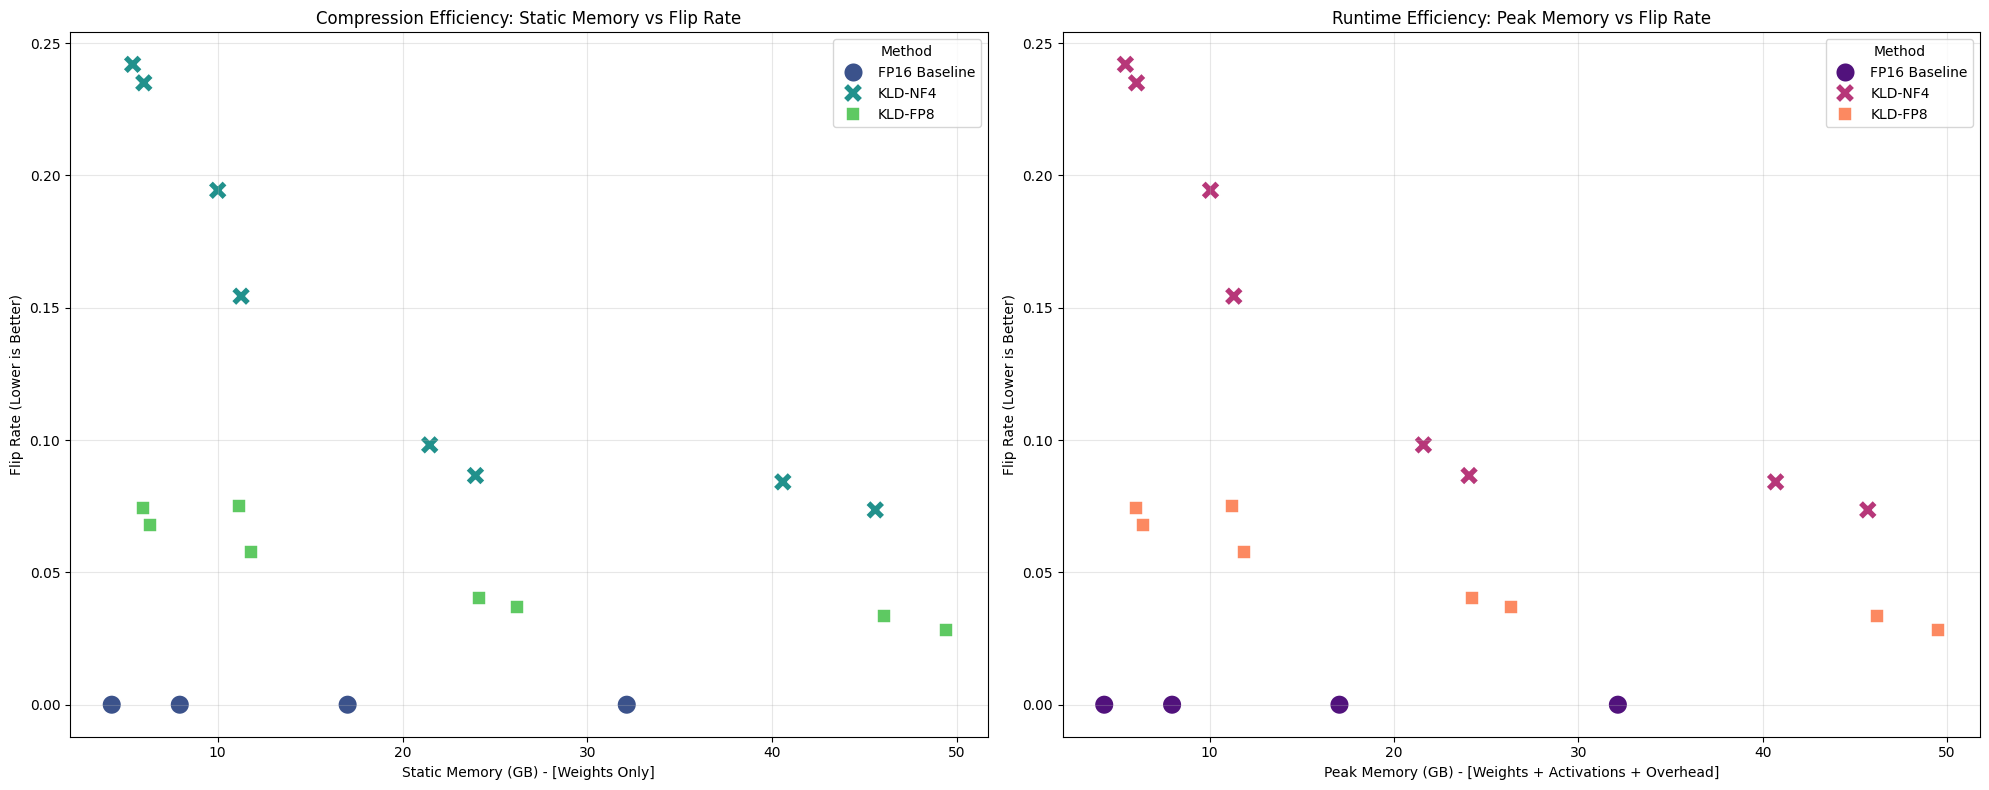

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create DataFrame
df = pd.DataFrame(results_table)

# Display the data
# print(df)

# 2. Set up the figure with 2 subplots (Static vs Peak)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot A: Static Memory (Model Size) vs Flip Rate ---
sns.scatterplot(
    data=df, x='Static Mem', y='Flip', hue='Method', style='Method',
    s=200, palette='viridis', ax=axes[0]
)
axes[0].set_title("Compression Efficiency: Static Memory vs Flip Rate")
axes[0].set_xlabel("Static Memory (GB) - [Weights Only]")
axes[0].set_ylabel("Flip Rate (Lower is Better)")
axes[0].grid(True, alpha=0.3)

# Add labels for Plot A
for i in range(df.shape[0]):
    row = df.iloc[i]
    # Check if 'Static_Mem' exists to avoid errors
    if 'Static_Mem' in row:
        axes[0].text(row.Static_Mem + 0.01, row.Flip + 0.001, f"{row.Threshold:.0%}", fontsize=9)

# --- Plot B: Peak Memory (Runtime Cost) vs Flip Rate ---
sns.scatterplot(
    data=df, x='Peak Mem', y='Flip', hue='Method', style='Method',
    s=200, palette='magma', ax=axes[1]
)
axes[1].set_title("Runtime Efficiency: Peak Memory vs Flip Rate")
axes[1].set_xlabel("Peak Memory (GB) - [Weights + Activations + Overhead]")
axes[1].set_ylabel("Flip Rate (Lower is Better)")
axes[1].grid(True, alpha=0.3)

# Add labels for Plot B
for i in range(df.shape[0]):
    row = df.iloc[i]
    if 'Peak_Mem' in row:
        axes[1].text(row.Peak_Mem + 0.05, row.Flip + 0.001, f"{row.Threshold:.0%}", fontsize=9)

plt.tight_layout()
plt.savefig("efficiency_frontier_comparison.png")
plt.show()

In [ ]:
baseline_map = df[df['Method'] == 'FP16 Baseline'].set_index('Model')['Static Mem'].to_dict()

# 4. Subtract ONLY for methods that are NOT the baseline
# This leaves the 'Static Mem' value for "FP16 Baseline" rows exactly as they were.
df['Static Mem'] = df.apply(
    lambda row: row['Static Mem'] - baseline_map.get(row['Model'], row['Static Mem'])
    if row['Method'] != 'FP16 Baseline' else row['Static Mem'],
    axis=1
)

# 5. Display the result
print(df)


                         Model         Method  Threshold     Acc    Flip  \
0   Qwen/Qwen2.5-1.5B-Instruct  FP16 Baseline        0.0  0.5728  0.0000   
1   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4        0.0  0.5376  0.2420   
2   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4        0.2  0.5248  0.2350   
3   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8        0.0  0.5734  0.0744   
4   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8        0.2  0.5710  0.0678   
5     Qwen/Qwen2.5-3B-Instruct  FP16 Baseline        0.0  0.6178  0.0000   
6     Qwen/Qwen2.5-3B-Instruct        KLD-NF4        0.0  0.6002  0.1944   
7     Qwen/Qwen2.5-3B-Instruct        KLD-NF4        0.2  0.6102  0.1544   
8     Qwen/Qwen2.5-3B-Instruct        KLD-FP8        0.0  0.6140  0.0750   
9     Qwen/Qwen2.5-3B-Instruct        KLD-FP8        0.2  0.6162  0.0576   
10    Qwen/Qwen2.5-7B-Instruct  FP16 Baseline        0.0  0.7226  0.0000   
11    Qwen/Qwen2.5-7B-Instruct        KLD-NF4        0.0  0.7150  0.0982   
12    Qwen/Q

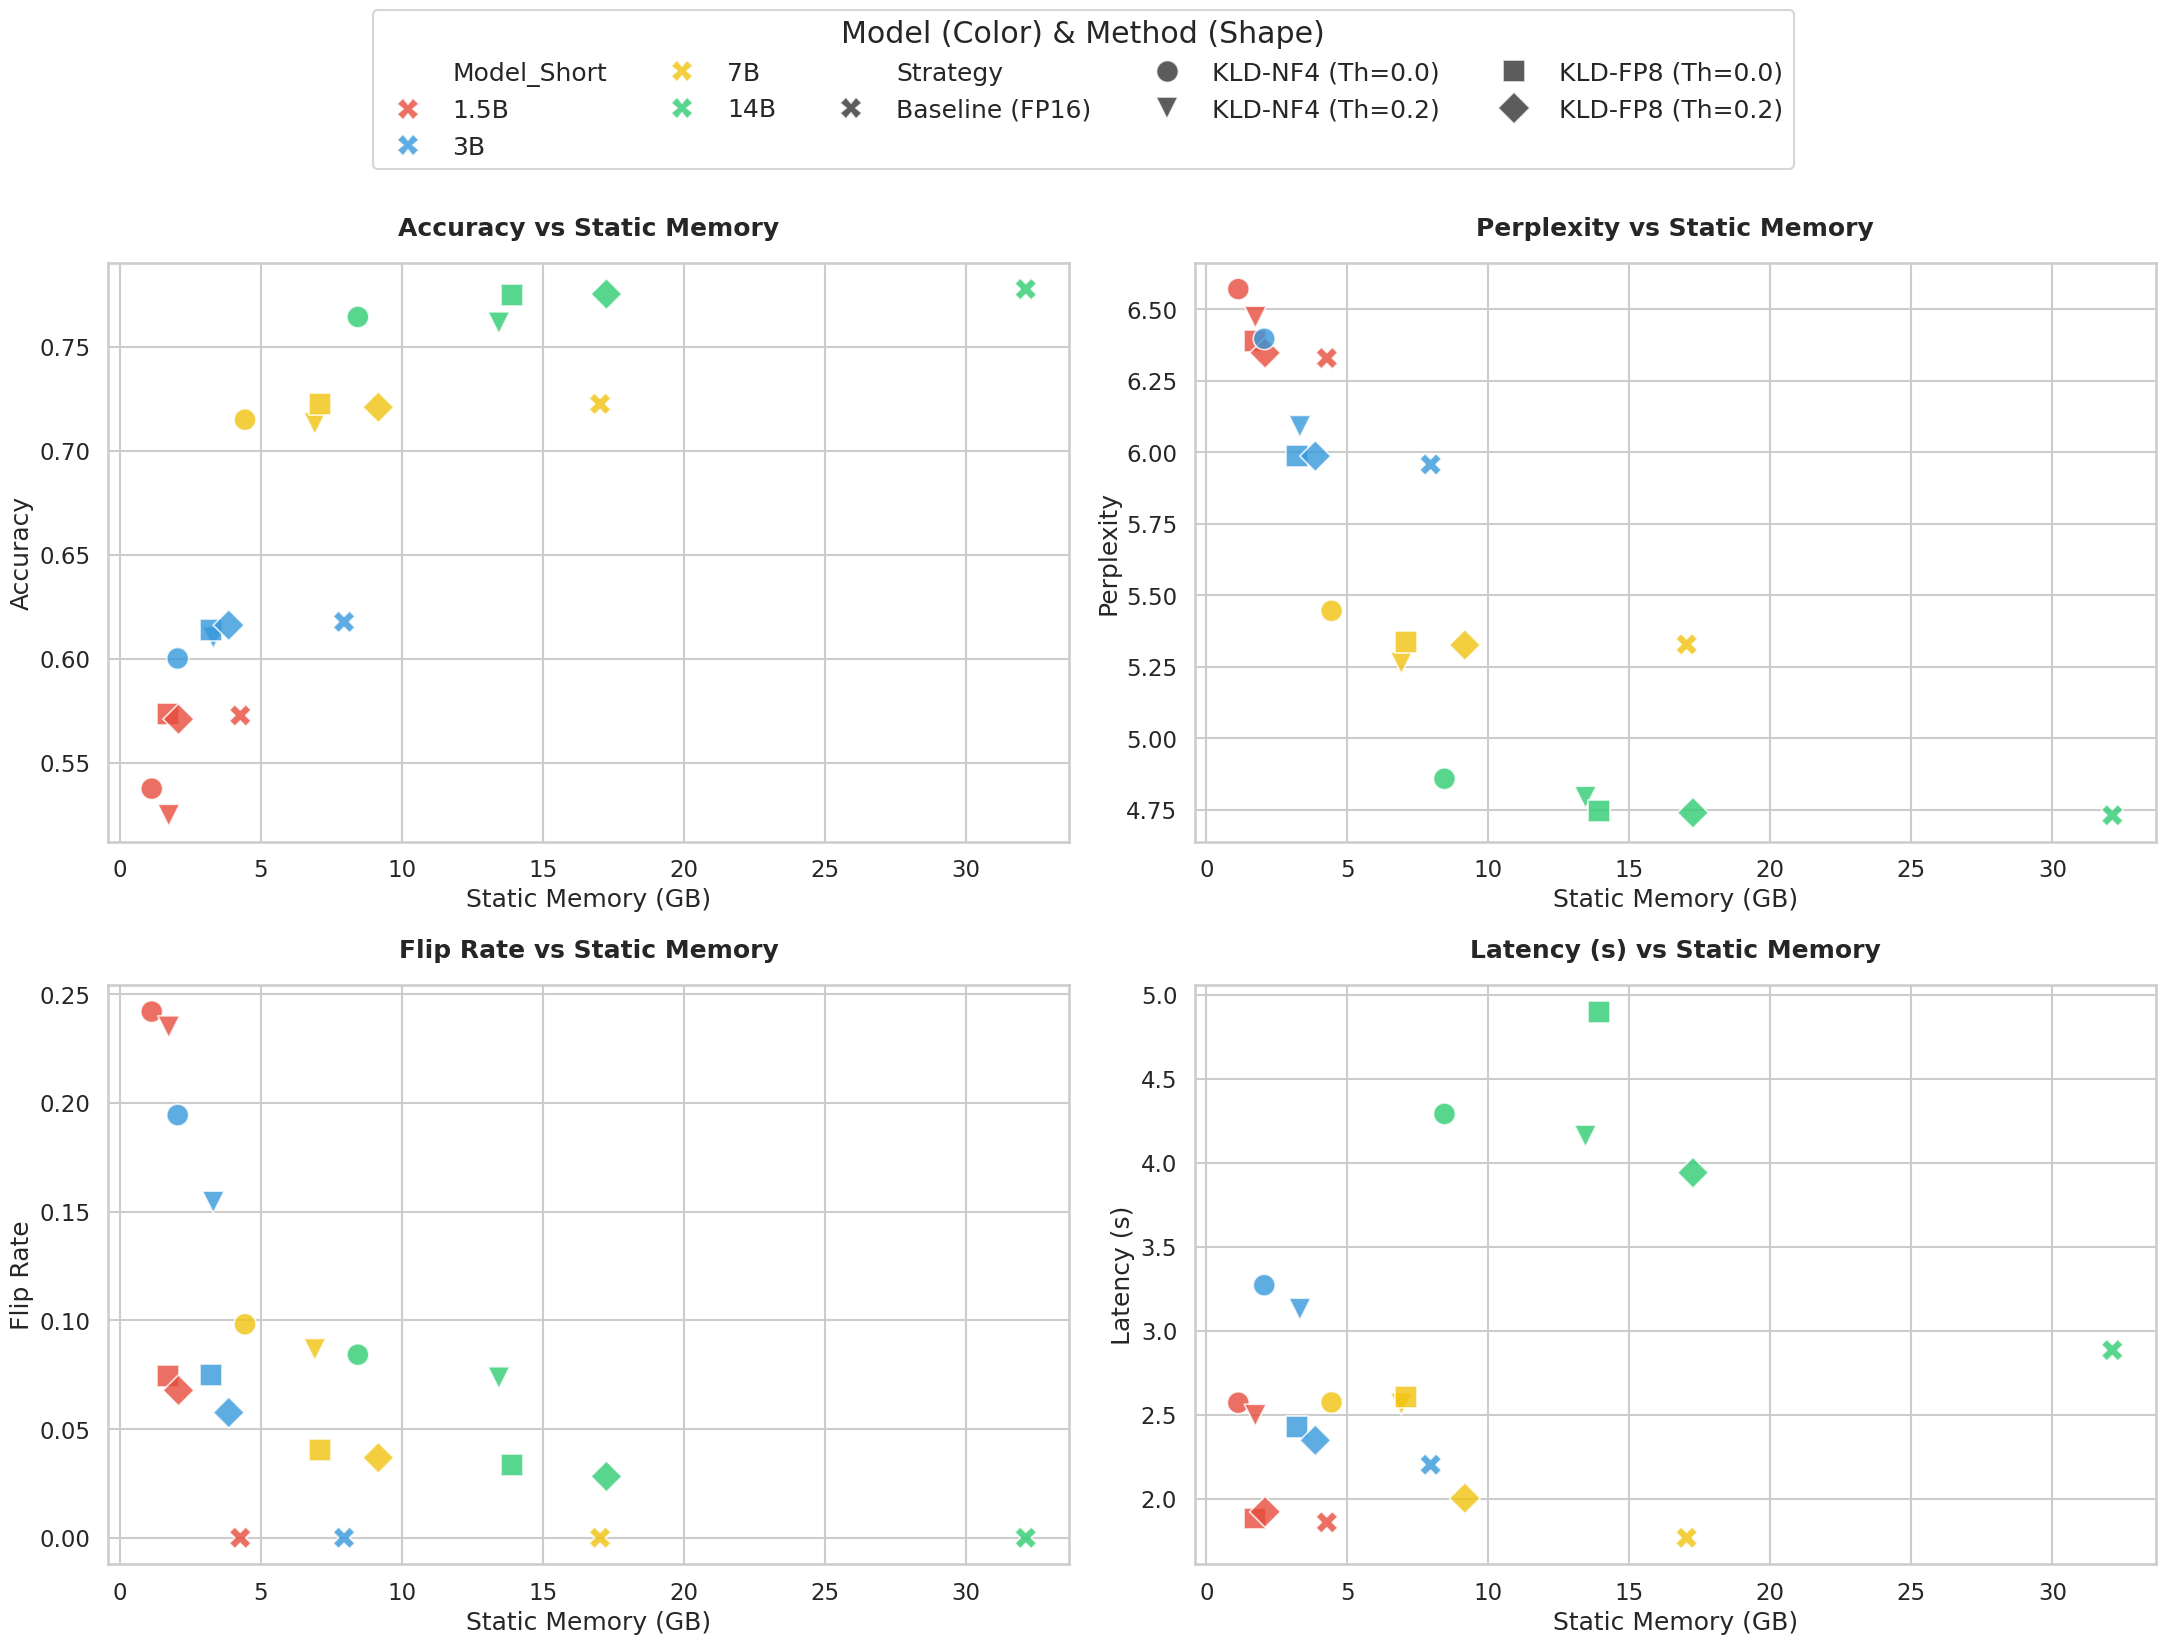

In [ ]:
import re

# 2. Extract clean Model Labels (1.5B, 3B, etc.)
def get_clean_label(model_name):
    match = re.search(r"(\d+(\.\d+)?[BM])", model_name)
    if match:
        return match.group(1)
    return model_name

df['Model_Short'] = df['Model'].apply(get_clean_label)

# 3. Create Strategy Column for Shapes
def get_strategy(row):
    if row['Method'] == 'FP16 Baseline':
        return 'Baseline (FP16)'
    return f"{row['Method']} (Th={row['Threshold']})"

df['Strategy'] = df.apply(get_strategy, axis=1)

# 4. Visualization Settings
sns.set_theme(style="whitegrid", context="talk")
# Increased figsize slightly to give more breathing room
fig, axes = plt.subplots(2, 2, figsize=(22, 16))
axes = axes.flatten()

metrics_map = [
    ('Acc', 'Accuracy', 'higher'),
    ('PPL', 'Perplexity', 'lower'),
    ('Flip', 'Flip Rate', 'lower'),
    ('Latency', 'Latency (s)', 'lower')
]

model_colors = {"1.5B": "#e74c3c", "3B": "#3498db", "7B": "#f1c40f", "14B": "#2ecc71"}
strategy_markers = {
    "Baseline (FP16)": "X",
    "KLD-NF4 (Th=0.0)": "o",
    "KLD-NF4 (Th=0.2)": "v",
    "KLD-FP8 (Th=0.0)": "s",
    "KLD-FP8 (Th=0.2)": "D"
}

for i, (col, label, _) in enumerate(metrics_map):
    ax = axes[i]
    sns.scatterplot(
        data=df, x='Static Mem', y=col,
        hue='Model_Short', style='Strategy',
        palette=model_colors, markers=strategy_markers,
        s=250, ax=ax, alpha=0.8
    )
    ax.set_title(f"{label} vs Static Memory", fontweight='bold', pad=20) # Added pad for title safety
    ax.set_xlabel("Static Memory (GB)")
    ax.set_ylabel(label)
    ax.get_legend().remove()

# --- THE FIX ---
handles, labels = axes[0].get_legend_handles_labels()

# 1. Increased bbox_to_anchor y-value (from 1.05 to 1.1)
# 2. Changed loc to 'upper center'
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.07),
           ncol=5, fontsize='medium',
           title="Model (Color) & Method (Shape)", title_fontsize='large')

# 3. Use tight_layout with a 'rect' padding at the top for the legend
# rect=[left, bottom, right, top] - we set top to 0.93 to leave 7% of space for the legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('efficiency_frontier_comparison.png', bbox_inches='tight')
plt.show()

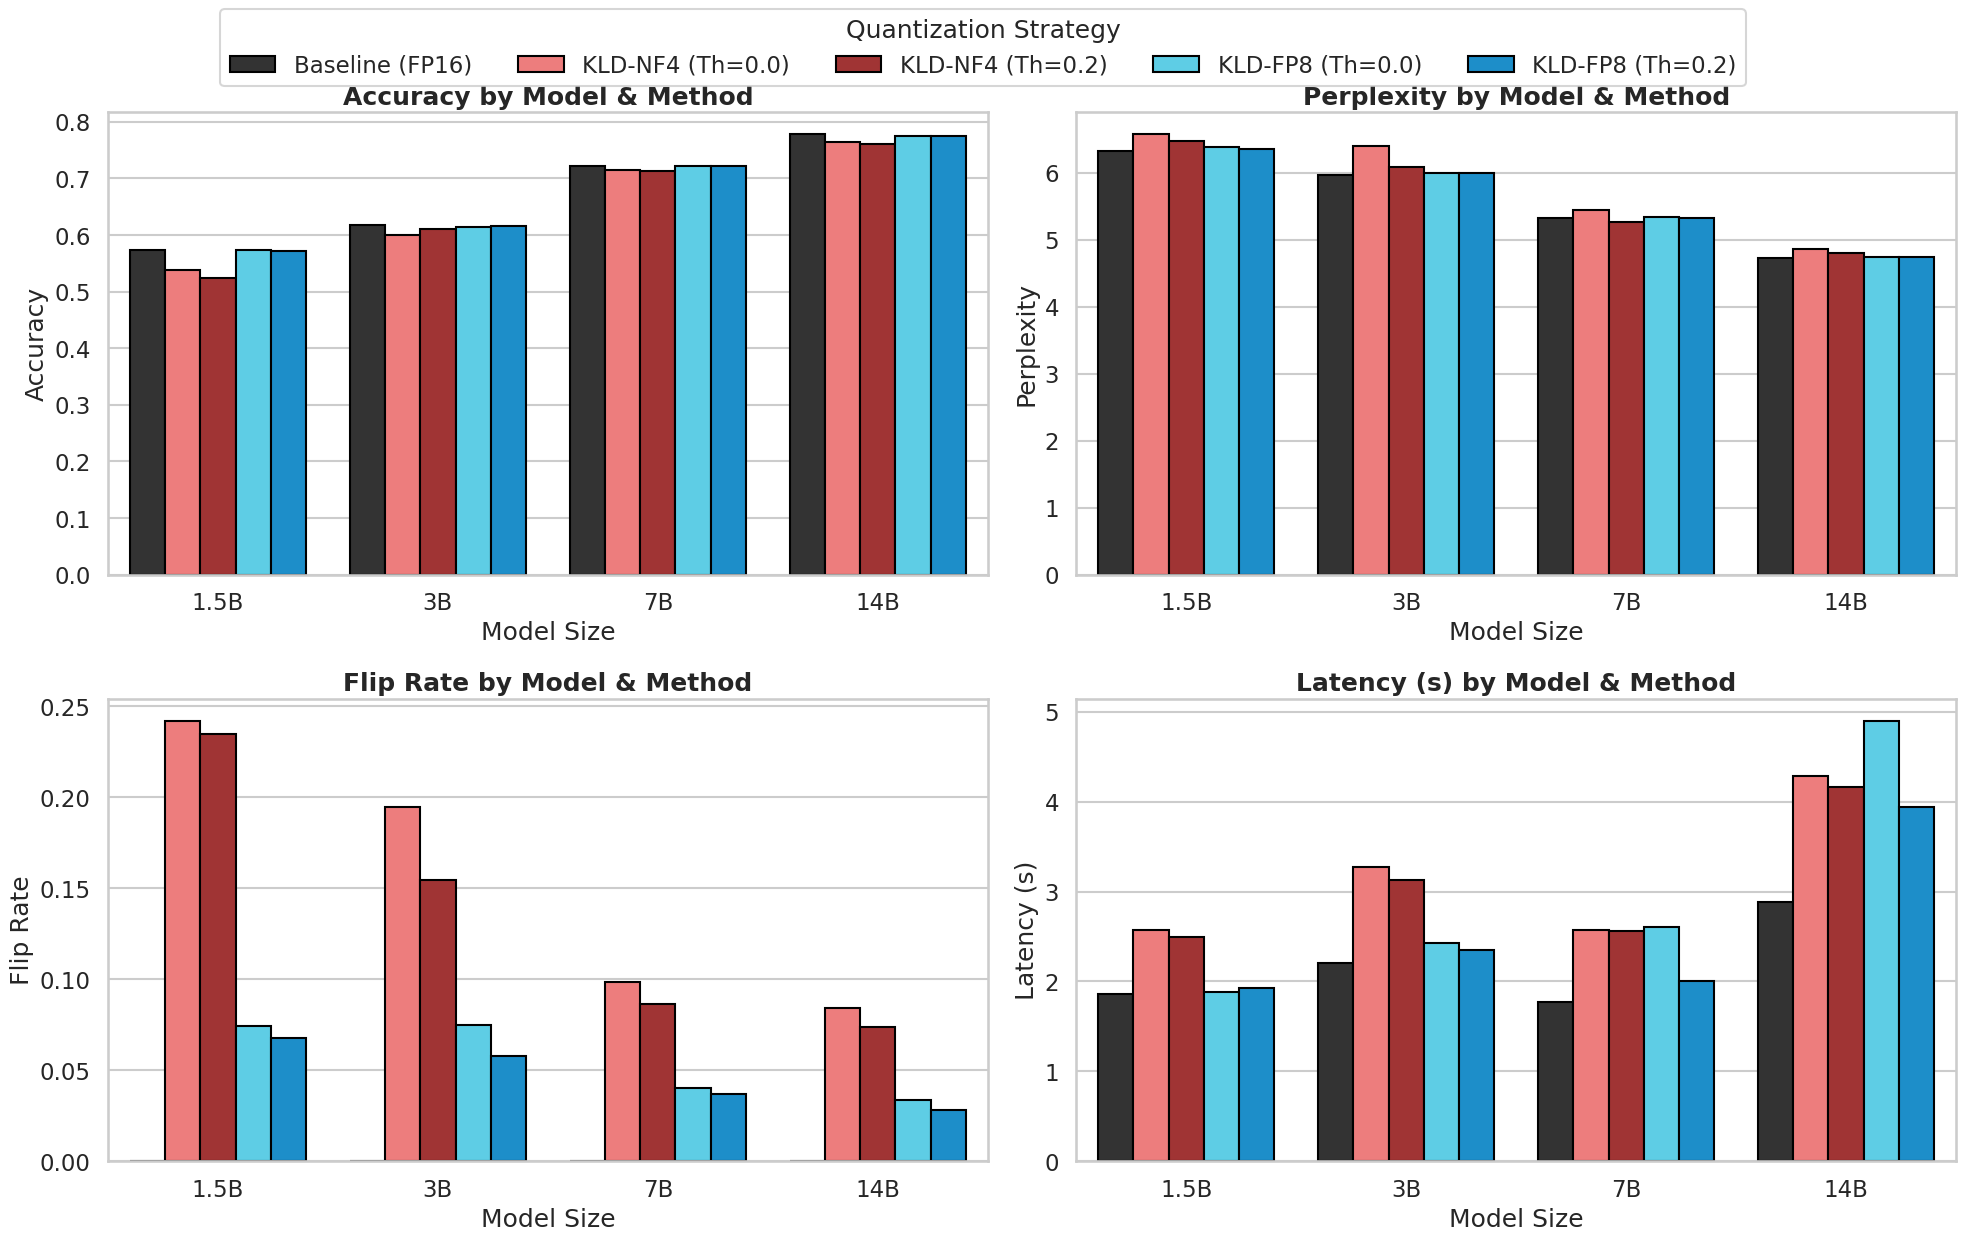

In [ ]:
# 2. Extract clean Model Labels (1.5B, 3B, etc.)
def get_clean_label(model_name):
    match = re.search(r"(\d+(\.\d+)?[BM])", model_name)
    if match:
        return match.group(1)
    return model_name

df['Model_Short'] = df['Model'].apply(get_clean_label)

# 3. Create Strategy Column
def get_strategy(row):
    if row['Method'] == 'FP16 Baseline':
        return 'Baseline (FP16)'
    return f"{row['Method']} (Th={row['Threshold']})"

df['Strategy'] = df.apply(get_strategy, axis=1)

# 4. Visualization
sns.set_theme(style="whitegrid", context="talk")
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

metrics_map = [
    ('Acc', 'Accuracy', 'higher'),
    ('PPL', 'Perplexity', 'lower'),
    ('Flip', 'Flip Rate', 'lower'),
    ('Latency', 'Latency (s)', 'lower')
]

# Custom Colors
strategy_colors = {
    "Baseline (FP16)": "#333333",  # Dark Grey
    "KLD-NF4 (Th=0.0)": "#FF6B6B", # Light Red
    "KLD-NF4 (Th=0.2)": "#B22222", # Dark Red
    "KLD-FP8 (Th=0.0)": "#48DBFB", # Light Blue
    "KLD-FP8 (Th=0.2)": "#0097E6"  # Dark Blue
}

for i, (col, label, _) in enumerate(metrics_map):
    ax = axes[i]
    sns.barplot(
        data=df,
        x='Model_Short',
        y=col,
        hue='Strategy',
        palette=strategy_colors,
        ax=ax,
        edgecolor='black'
    )

    ax.set_title(f"{label} by Model & Method", fontweight='bold')
    ax.set_xlabel("Model Size")
    ax.set_ylabel(label)

    # Hide individual legends
    ax.get_legend().remove()

# Add Global Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, title="Quantization Strategy")

plt.tight_layout()
plt.savefig('metrics_comparison.png')
plt.show()

# Store

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil # Import shutil for copying files

# Define the directory to save files in Google Drive
save_dir = '/content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp3'
os.makedirs(save_dir, exist_ok=True)

# Save results_table as CSV
df_results = pd.DataFrame(results_table)
df_results.to_csv(os.path.join(save_dir, 'exp3_results.csv'), index=False)
print(f"Results table saved to {os.path.join(save_dir, 'exp3_results.csv')}") # Corrected print statement

# Copy figures to Google Drive
figures_to_copy = [
    'efficiency_frontier_comparison.png',
    'metrics_comparison.png'
]

for fig_name in figures_to_copy:
    fig_path = os.path.join('/content', fig_name)
    if os.path.exists(fig_path):
        # Use shutil.copy2 to copy the file, then os.remove to delete the original
        shutil.copy2(fig_path, os.path.join(save_dir, fig_name))
        # os.remove(fig_path) # Remove original after copying
        print(f"Copied {fig_name} to {os.path.join(save_dir, fig_name)} and removed original.")
    else:
        print(f"Figure {fig_name} not found in current directory.")

Results table saved to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp3/exp3_results.csv
Copied efficiency_frontier_comparison.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp3/efficiency_frontier_comparison.png and removed original.
Copied metrics_comparison.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp3/metrics_comparison.png and removed original.
